# Note:

**В этом ноутбуке, а также в аналогичном для Pyramid рассматривается влияние начало и конца промежутка для обучения на качество модели.**

In [1]:
import pandas as pd
import numpy as np
import math
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

from fbprophet import Prophet

from sklearn.metrics import mean_absolute_error

np.random.seed(123)

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))

# Generating data

In [3]:
def f_1(time):
    """
    time: np.array (len_ts,)
    """
    return time.reshape(-1,1)

def f_2(time):
    noise = np.random.randn(time.shape[0])
    f = lambda t: t * np.sin(t) + 200
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return (f_time+noise).reshape(-1,1)

def f_3(time, period):
    f = lambda t: 100 * np.sin(t // period) + 100 + 2*t
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return f_time.reshape(-1,1)

def f_4(time, period):
    f = lambda t: 100 * np.cos(t // period) + 100 + 2*t
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return f_time.reshape(-1,1)

def generate_ts_1(exog):
    """
    exog: np.array (len_ts, k_exog)
    """
    a = (np.ones(exog.shape[1])/exog.shape[1]).reshape(-1,1)
    y = exog @ a
    return y

def generate_ts_2(exog):
    y = np.zeros(exog.shape[0])
    a = (np.ones(exog.shape[1])/exog.shape[1]).reshape(-1,1)
    for i in range(exog.shape[0]):
        y[i] = exog[i] @ a
        if (y[i-1] != None):
            y[i] = y[i] + 0.3 * y[i-1]
        if (y[i-2] != None):
            y[i] = y[i] + 0.2 * y[i-2]
        if (y[i-3] != None):
            y[i] = y[i] + 0.1 * y[i-3]
    return y
    

In [4]:
Time = np.arange(0, 300)

# Plotting features

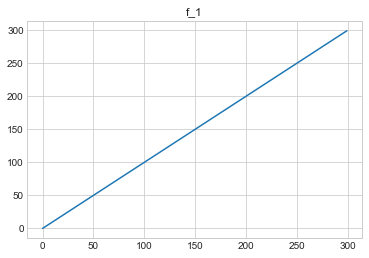

In [5]:
plt.plot(Time,f_1(Time))
plt.title("f_1")
plt.show()

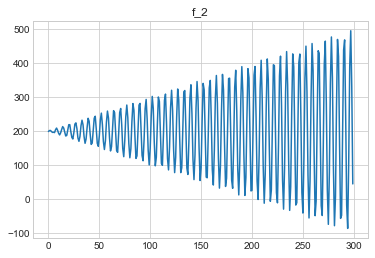

In [6]:
plt.plot(Time,f_2(Time))
plt.title("f_2")
plt.show()

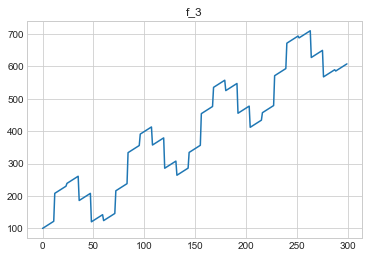

In [7]:
plt.plot(Time,f_3(Time, period=12))
plt.title("f_3")
plt.show()

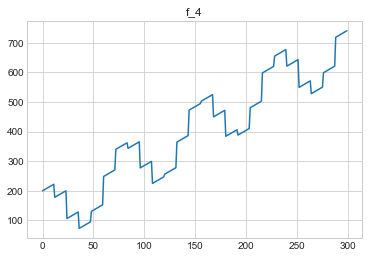

In [8]:
plt.plot(Time,f_4(Time,period=12))
plt.title("f_4")
plt.show()

# Plotting time-series

In [9]:
Exog = np.concatenate([f_1(Time),f_2(Time),f_3(Time, period=12),f_4(Time, period=12)], axis = 1)

In [10]:
Exog.shape

(300, 4)

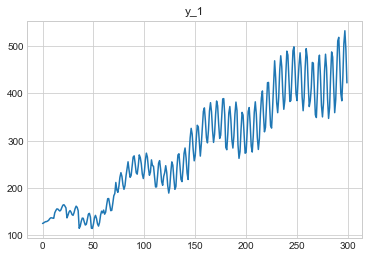

In [11]:
y_1 = generate_ts_1(Exog)

plt.plot(Time,y_1)
plt.title("y_1")
plt.show()

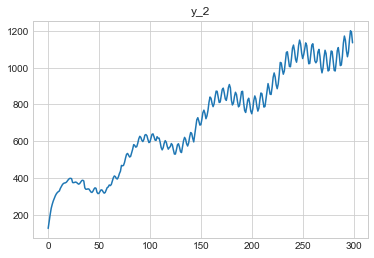

In [12]:
y_2 = generate_ts_2(Exog)

plt.plot(Time,y_2)
plt.title("y_2")
plt.show()

# Prophet Approach

In [13]:
data_1 = pd.DataFrame(y_1)
data_1.columns = ["y"]
data_1["ds"] = pd.date_range(start='1/1/2018', periods=len(data_1), freq='M')

data_2 = pd.DataFrame({"y": y_2})
data_2["ds"] = pd.date_range(start='1/1/2018', periods=len(data_2), freq='M')

exog = pd.DataFrame(Exog)
exog.columns = ["f1", "f2", "f3", "f4"]
exog["ds"] = pd.date_range(start='1/1/2018', periods=len(exog), freq='M')

print(data_1.shape, data_2.shape, exog.shape)

(300, 2) (300, 2) (300, 5)


In [14]:
data_1.head()

,y,ds
0,125.191264,2018-01-31
1,126.253121,2018-02-28
2,127.789861,2018-03-31
3,129.008621,2018-04-30
4,129.207194,2018-05-31


In [15]:
data_2.shape

(300, 2)

In [16]:
exog.head()

,f1,f2,f3,f4,ds
0,0.0,200.765055,100.0,200.0,2018-01-31
1,1.0,200.012482,102.0,202.0,2018-02-28
2,2.0,201.159444,104.0,204.0,2018-03-31
3,3.0,201.034484,106.0,206.0,2018-04-30
4,4.0,196.828777,108.0,208.0,2018-05-31


In [17]:
start_point = 80
middle_point = 125
end_point = 175

data_train_1 = data_1.iloc[start_point: middle_point]
data_test_1 = data_1.iloc[middle_point: end_point]

data_train_2 = data_2.iloc[start_point: middle_point]
data_test_2 = data_2.iloc[middle_point: end_point]

exog_train = exog.iloc[start_point: middle_point]
exog_test = exog.iloc[middle_point: end_point]

In [18]:
y_test_1 = data_test_1["y"].values
del data_test_1["y"]

y_test_2 = data_test_2["y"].values
del data_test_2["y"]

# 1 Experiment: 1-st dataset without exog

In [19]:
# Python
model = Prophet()

#model.add_seasonality(
#    name='montly', period=7, fourier_order=3, prior_scale=0.1)

model.fit(data_train_1)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [20]:
forecast = model.predict(data_test_1)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
45,2032-03-31,177.959382,155.421824,202.502581
46,2032-04-30,163.882532,142.077833,188.448372
47,2032-05-31,164.404890,141.701085,190.964018
48,2032-06-30,211.218899,187.031593,236.414112
49,2032-07-31,218.862482,193.477140,245.949189


In [21]:
mape = np.round(mean_absolute_percentage_error(forecast["yhat"], y_test_1), 3)

mae = np.round(mean_absolute_error(forecast["yhat"], y_test_1), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.462 
 MAE:  89.297


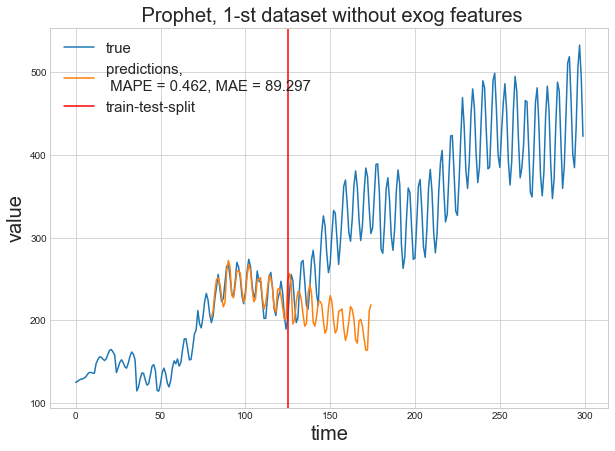

In [22]:
forecast_test = model.predict(data_test_1)
forecast_train = model.predict(data_train_1)

plt.figure(figsize=(10,7))

plt.plot(Time, y_1, label = "true")
plt.plot(Time[start_point: end_point], np.concatenate([forecast_train["yhat"].values, forecast_test["yhat"].values]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=middle_point, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title(" Prophet, 1-st dataset without exog features", size = 20)



plt.legend(fontsize = 15)

plt.show()

# 2 Experiment: 2-nd dataset without exog

In [23]:
# Python
model = Prophet(n_changepoints=100, changepoint_range=1)
model.fit(data_train_2)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 44.0.
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/fbprophet/forecaster.py:353: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  np.linspace(0, hist_size - 1, self.n_changepoints + 1)
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [24]:
forecast = model.predict(data_test_2)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
45,2032-03-31,490.721957,389.692169,602.067614
46,2032-04-30,472.609296,368.438982,589.122244
47,2032-05-31,463.322659,356.845664,578.895404
48,2032-06-30,506.450386,397.398412,628.991745
49,2032-07-31,515.505061,400.764916,638.360986


In [25]:
mape = np.round(mean_absolute_percentage_error(forecast["yhat"], y_test_2), 3)

mae = np.round(mean_absolute_error(forecast["yhat"], y_test_2), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.365 
 MAE:  186.219


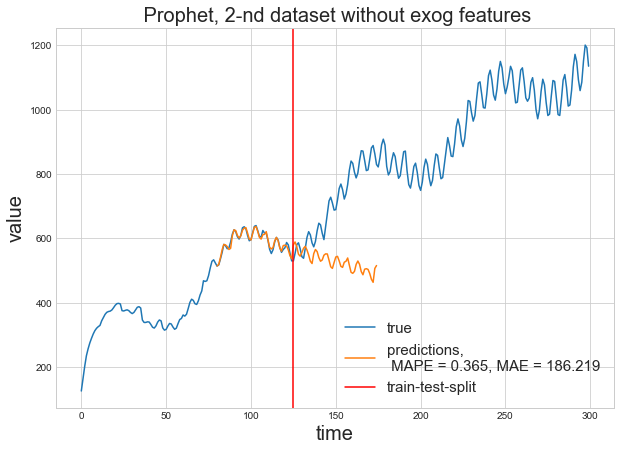

In [26]:
forecast_test = model.predict(data_test_2)
forecast_train = model.predict(data_train_2)

plt.figure(figsize=(10,7))

plt.plot(Time, y_2, label = "true")
plt.plot(Time[start_point: end_point], np.concatenate([forecast_train["yhat"].values, forecast_test["yhat"].values]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=middle_point, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title(" Prophet, 2-nd dataset without exog features", size = 20)



plt.legend(fontsize = 15)

plt.show()

# Merging of features

In [27]:
data_train_1_new = pd.merge(data_train_1, exog_train, on = "ds")

data_test_1_new = pd.merge(data_test_1, exog_test, on = "ds")

print(data_train_1_new.shape, data_test_1_new.shape)
data_train_1_new.head()

(45, 6) (50, 5)


,y,ds,f1,f2,f3,f4
0,197.338554,2024-09-30,80.0,121.278736,232.05845,356.017029
1,205.261761,2024-10-31,81.0,147.971564,234.05845,358.017029
2,225.613613,2024-11-30,82.0,224.378974,236.05845,360.017029
3,240.641725,2024-12-31,83.0,279.491421,238.05845,362.017029
4,255.582696,2025-01-31,84.0,261.241897,333.69866,343.390225


# 3-rd Experiment: 1-st dataset with exog features

In [28]:
data_train_2_new = pd.merge(data_train_2, exog_train, on = "ds")

data_test_2_new = pd.merge(data_test_2, exog_test, on = "ds")

print(data_train_2_new.shape, data_test_2_new.shape)
data_train_2_new.head()

(45, 6) (50, 5)


,y,ds,f1,f2,f3,f4
0,513.832347,2024-09-30,80.0,121.278736,232.05845,356.017029
1,517.387245,2024-10-31,81.0,147.971564,234.05845,358.017029
2,535.920624,2024-11-30,82.0,224.378974,236.05845,360.017029
3,556.278596,2024-12-31,83.0,279.491421,238.05845,362.017029
4,581.389124,2025-01-31,84.0,261.241897,333.69866,343.390225


In [29]:
model = Prophet()

model.add_regressor("f1")
model.add_regressor("f2")
model.add_regressor("f3")
model.add_regressor("f4")

model.fit(data_train_1_new)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [30]:
forecast = model.predict(data_test_1_new)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
45,2032-03-31,355.553579,355.269178,355.837187
46,2032-04-30,384.023590,383.730189,384.312978
47,2032-05-31,373.869748,373.567281,374.171798
48,2032-06-30,335.537081,335.214439,335.855404
49,2032-07-31,304.925267,304.598626,305.249133


In [31]:
mape = np.round(mean_absolute_percentage_error(forecast["yhat"], y_test_1), 3)

mae = np.round(mean_absolute_error(forecast["yhat"], y_test_1), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.0 
 MAE:  0.02


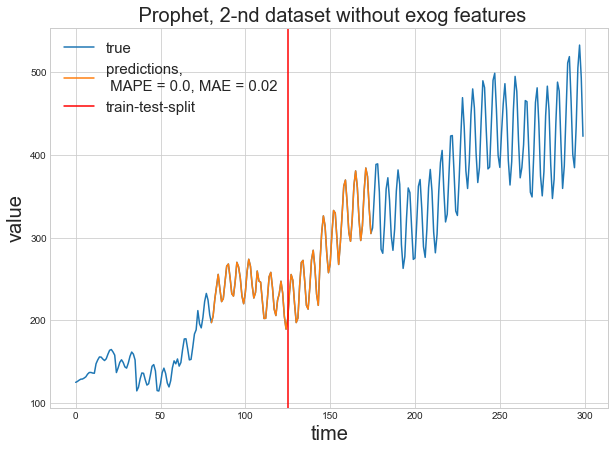

In [32]:
forecast_test = model.predict(data_test_1_new)
forecast_train = model.predict(data_train_1_new)

plt.figure(figsize=(10,7))

plt.plot(Time, y_1, label = "true")
plt.plot(Time[start_point: end_point], np.concatenate([forecast_train["yhat"].values, forecast_test["yhat"].values]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=middle_point, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title(" Prophet, 2-nd dataset without exog features", size = 20)



plt.legend(fontsize = 15)

plt.show()

# 4-th Experiment: 2-nd dataset with exog features

In [33]:
model = Prophet()

model.add_regressor("f1")
model.add_regressor("f2")
model.add_regressor("f3")
model.add_regressor("f4")

model.fit(data_train_2_new)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [34]:
forecast = model.predict(data_test_2_new)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
45,2032-03-31,865.557593,388.847332,1336.907244
46,2032-04-30,893.567548,398.903434,1380.594586
47,2032-05-31,875.586850,361.010421,1376.095185
48,2032-06-30,842.101536,307.995179,1358.259399
49,2032-07-31,818.981639,261.658922,1354.685417


In [35]:
mape = np.round(mean_absolute_percentage_error(forecast["yhat"], y_test_2), 3)

mae = np.round(mean_absolute_error(forecast["yhat"], y_test_2), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.028 
 MAE:  19.274


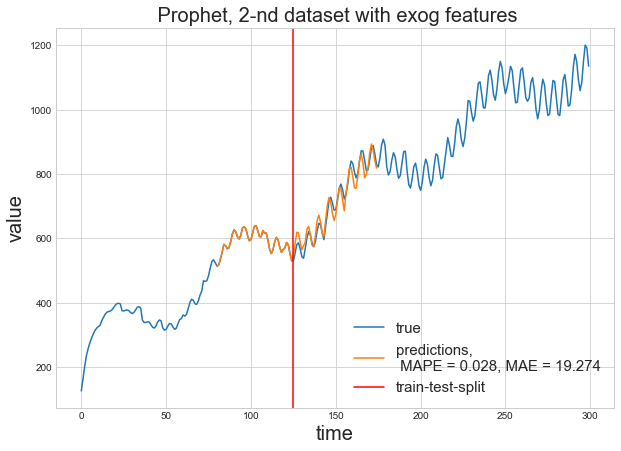

In [36]:
forecast_test = model.predict(data_test_2_new)
forecast_train = model.predict(data_train_2_new)

plt.figure(figsize=(10,7))

plt.plot(Time, y_2, label = "true")
plt.plot(Time[start_point: end_point], np.concatenate([forecast_train["yhat"].values, forecast_test["yhat"].values]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=middle_point, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title(" Prophet, 2-nd dataset with exog features", size = 20)



plt.legend(fontsize = 15)

plt.show()

# Model Params:

In [37]:
model.params

{'k': array([[0.06341155]]),
 'm': array([[0.92344163]]),
 'delta': array([[ 0.00165675,  0.02610215, -0.00443188,  0.01596816,  0.38879967,
         -0.09252311, -0.5322664 ,  0.02716825,  0.08157243,  0.0948855 ,
         -0.27463036, -0.01533584, -0.0105327 ,  0.10507423,  0.08353564,
          0.00693155, -0.04311917,  0.08374295,  0.1225347 , -0.38365421,
          0.00497109, -0.31991988,  0.00612727,  0.47168585,  0.22689694]]),
 'sigma_obs': array([[0.00033184]]),
 'beta': array([[-0.00245696,  0.00371865,  0.02595847,  0.00097224,  0.04840304,
          0.02983423,  0.0433449 ,  0.02458111,  0.0231408 ,  0.01660203,
          0.05521673,  0.0074042 ,  0.0268649 , -0.01650883,  0.04394992,
         -0.01471639,  0.05254093, -0.01530457,  0.02673805, -0.00478938,
          0.0218518 ,  0.02801747,  0.03480327,  0.01184727]])}

**На последнем графике хорошо видно, что prophet хорошо предсказал значения ряда. В этом случае он оказался значительно сильнее SARIMAX. **

**То есть при маленькой выборке, Prophet проявляет себя лучше SARIMAX.**